<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

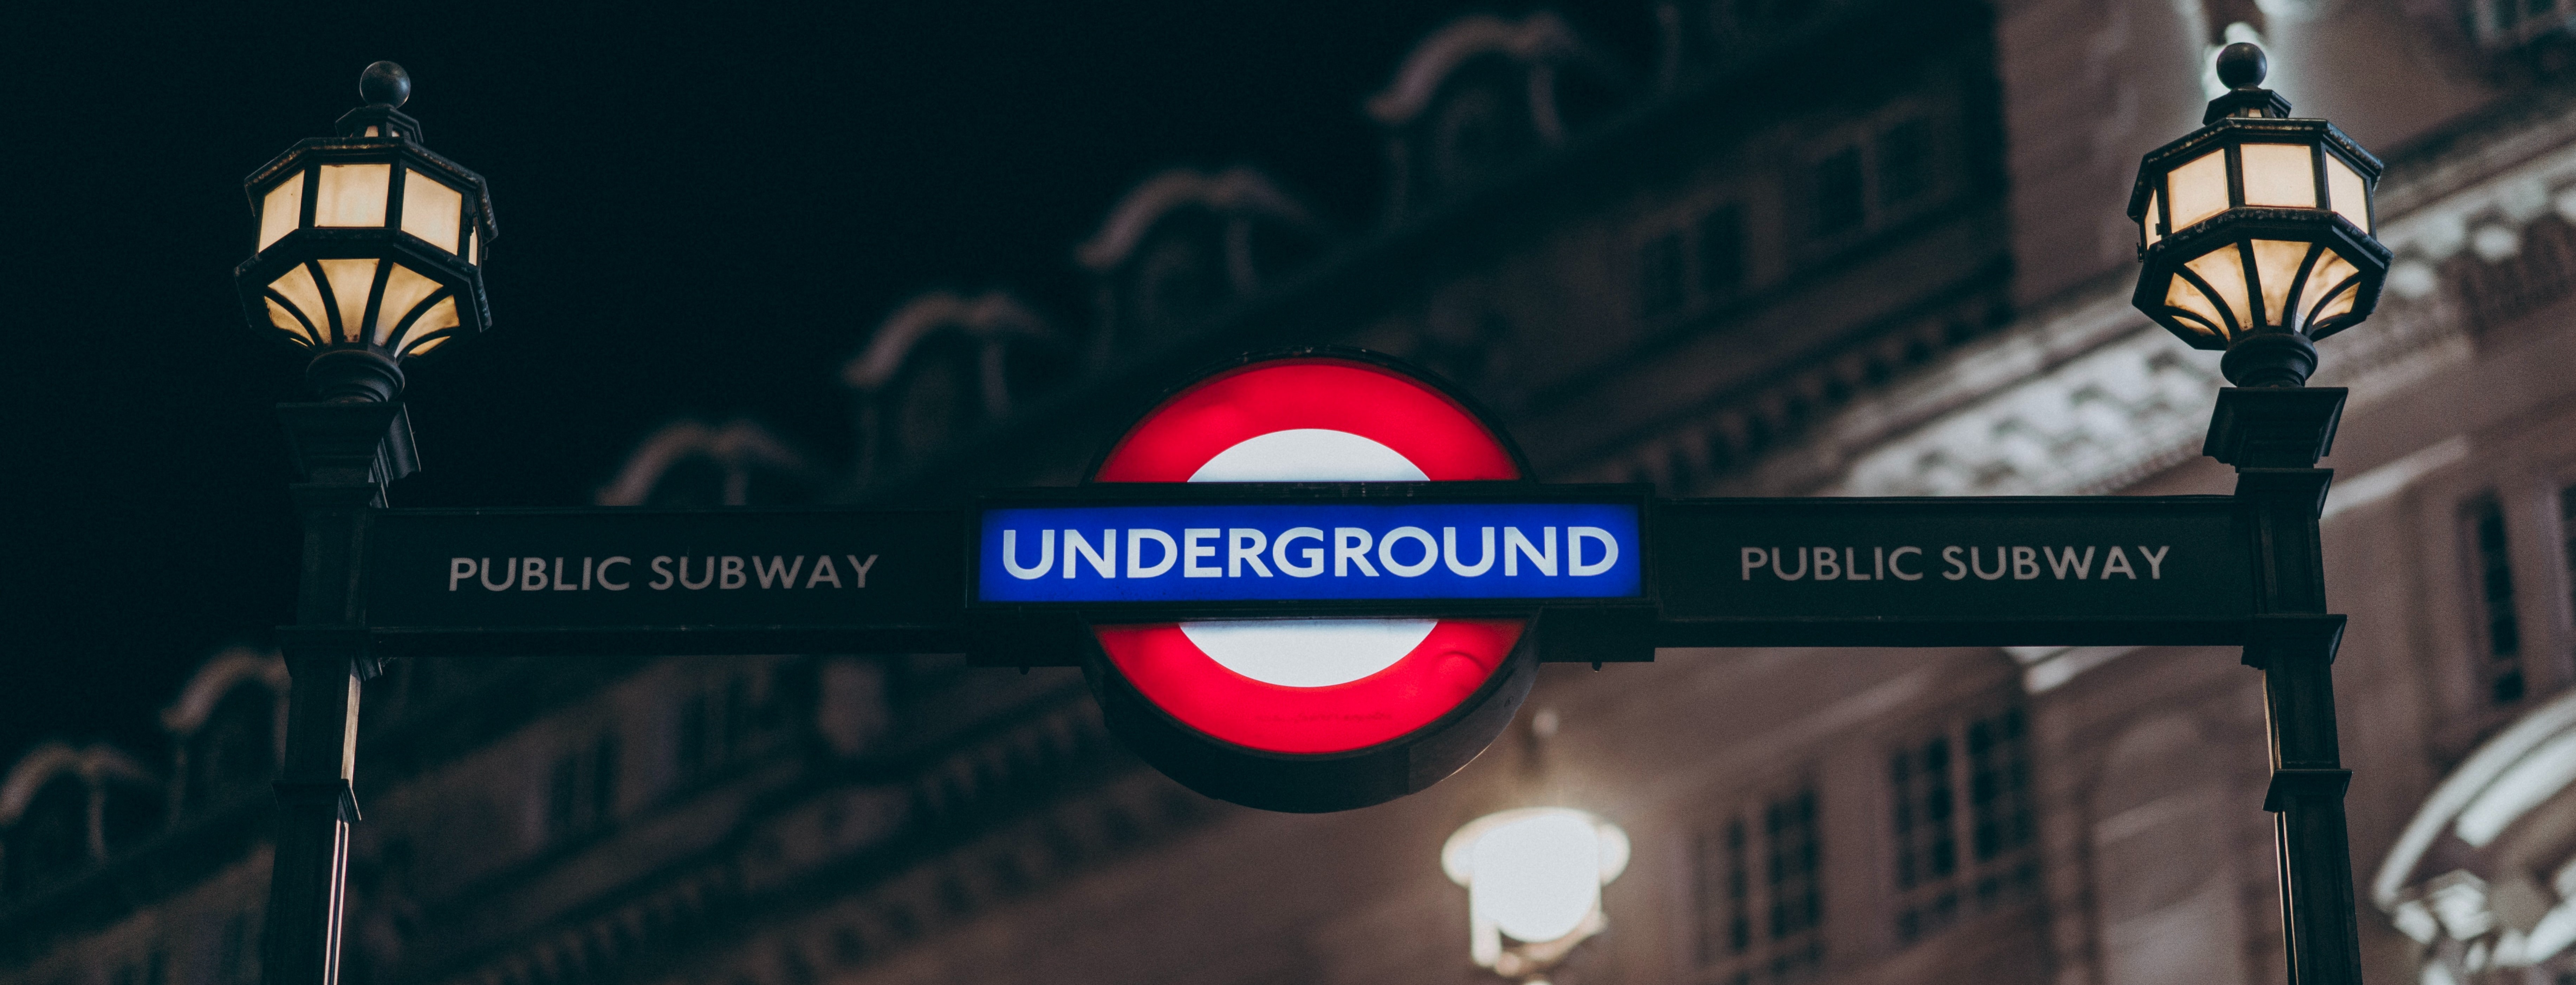

# Sections
* [Description](#0)
* [1. Setup](#1)
  * [1.1 Creation of the SparkSession and upload of Kafka libraries](#1.1)
  * [1.2 Library import](#1.2)
* [2. Stream Analysis - Alarm Table](#2)
  * [2.1 Build the Streaming DataFrame](#2.1)
  * [2.2 Creation of the Json schema](#2.2)
  * [2.3 Capture of the DataFrame using the Json schema](#2.3)
  * [2.4 Generation of the Alarm table](#2.4)
* [3. Stream Analysis - Frequency Table](#3)
  * [3.1 Generation of the Frequency table](#3.1)
* [Conclusion](#00)

<a id='0'></a>
# Description

As part of our contract with the local government body Transport for London, the objective of this notebook is to create a proof of concept to show that the complete architecture required and proposed is viable.

With this in mind, we will try to create mainly two reports:

1. Alarm table: 

    The Underground system works with a rigorous schedule, which must be respected to successfully respond to the huge demand of users (arround 1.8 millions daily). In this line, the "Alarm Table" will be able to show if a particular vehicle presents a delay. As it will be updated every two minutes and a half, this high frequency will allow the responsibles of keeping track to act quickly, increasing the probability of success. 
    
    For the sake of simplicity, the proof of concept will be done only for the Central line (the second busiest line). Further on, in our analysis, we consider the timestamp field "expected_arrival" as the schedule. This means that if it changes, that particular train (vehicle_id) is **not** respecting the schedule. 
    
    
2. Frequency table:
   
   Transport for London does not recieve a constant demand through the entire day, and the Underground system is not an exception. There are clearly hours of high people's waves (8 am - 10 am) while in other moments the demand is quite low (10 pm - 1 am). That is why we see different frequencies depending on the time of the day. Keeping a track of this is crucial for the good behaviour of the subway and this is what the "Frequency Table" aims to tackle. If we constantly show these numbers, the responsibles can act quickly if they see that something is not correct, disminuishing the impact of any unexpected event.
   
   For the proof of concept, we selected the second crowdest station, Victoria, and we will show the frequency that each of the three lines that passes in that station has.

<a id='1'></a>
## 1. Setup

<a id='1.1'></a>
### 1.1 Creation of the SparkSession and upload of Kafka libraries 

In [1]:
# Required step as we are working with a close enviorment.
import findspark
findspark.init()

# Import of Kafka libraries.
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1" pyspark-shell'

# Creation of the SparkSession called: "Underground Streaming".
from pyspark.sql.session import SparkSession

spark = SparkSession.builder\
                    .appName("Underground Streaming")\
                    .getOrCreate()

:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7dca8698-0d0c-41ac-b142-996686d8c484;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.2.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.2.1 in central
	found org.apache.kafka#kafka-clients;2.8.0 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.1 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.hadoop#hadoop-client-api;3.3.1 in central
	found org.apache.htrace#htrace-core4;4.1.0-incubating in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central

<a id='1.2'></a>
### 1.2 Library import

These are all the libraries that we are going to use in Spark:

In [2]:
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import *
from pyspark.sql.functions import window
from pyspark.sql.functions import regexp_replace

<a id='2'></a>
## 2. Stream Analysis - Alarm Table

<a id='2.1'></a>
### 2.1 Build the Streaming DataFrame

Firstly, we will create the **streaming** DataFrame, so afterwards we can make all the needed changes to show our objective. 

In [3]:
# "tube" is the topic name that NiFi uses when sending the information to Kafka.
df = spark.readStream\
                 .format("kafka") \
                 .option("kafka.bootstrap.servers", "localhost:9092") \
                 .option("subscribe", "tube") \
                 .option("startingOffsets", "latest") \
                 .option("kafka.group.id", "IE") \
                 .load()

<a id='2.2'></a>
### 2.2 Creation of the Json schema

This will allow us to infer the schema that the json documents sent by NiFi and captured in Spark via Kafka have.

In [4]:
jsonschema = StructType([StructField("vehicleId", StringType()),\
                         StructField("lineId", StringType()),\
                         StructField("naptanId", StringType()),\
                         StructField("direction", StringType()),\
                         StructField("destinationName", StringType()),\
                         StructField("stationName", StringType()),\
                         StructField("timestamp", TimestampType()),\
                         StructField("expectedArrival", StringType())])

<a id='2.3'></a>
### 2.3 Capture of the DataFrame using the Json schema

Now that we have the schema, we will grab the DataFrame captured in Spark using the Jason schema.

In [5]:
tube_stream = df.select(from_json(col("value").cast("string"), jsonschema) \
                        .alias("tube_values"))

tube_data = tube_stream.select("tube_values.*")

Finally we have our DataFrame that has the below structure.

In [6]:
tube_data.printSchema()

root
 |-- vehicleId: string (nullable = true)
 |-- lineId: string (nullable = true)
 |-- naptanId: string (nullable = true)
 |-- direction: string (nullable = true)
 |-- destinationName: string (nullable = true)
 |-- stationName: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- expectedArrival: string (nullable = true)



<a id='2.4'></a>
### 2.3 Generation of the Alarm table

Finally we have our DataFrame with information on it and a proper structure which we can work with.

In order to show the table in the way we want, we will need to make some calculations explained below. Let's remember that our aim here is to create a report where we can see, every one minute, if any train (vehicle id) has any delay (change in the **first** expectedArrival captured).

First we need to convert the column expectedArrival into timestamp as per the above schema it has string format:

In [7]:
tube_data = tube_data.withColumn('expectedArrival', regexp_replace('expectedArrival', 'T', ' ')) \
                     .withColumn('expectedArrival', regexp_replace('expectedArrival', 'Z', '')) \
                     .withColumn("expectedArrival", to_timestamp(col('expectedArrival'),'yyyy-MM-dd HH:mm:ss'))

After this transformation, we need to create the function that will allow us to calculate the delays. Here, once we use it, "x" will reffer to the actual timestamp and "i" to the index of that specific row. We will transorm the column selected into an array that will have all the historical values that we brought into Spark with each batch and will make a time difference between the first value and the last one. This will give us the actual delay and, as it will be utilized in a groupBy (which by defintion orders and separates the data it into the different groups), this number will be part of the same vehicle and station. 

We need to note that the expectedArrival field says at what time that particular vehicle is expected to arrive to the stationName. In the API, we can appreciate that each vehicle can have more than one station as a destination. Hence, if we find that a particular vehicle is not respecting the schedule, probably we will just find one row on the Alert Table with that particular station at which is expected to arrive late. If we start seeing a same vehicle id but with different stations, then we will see a cascade effect: as it didn't managed to arrive on time to the next station, it is not expected to mantain the schedule.

In [8]:
transform_expr = "transform(ts_array, (x,i) -> (unix_timestamp(ts_array[size(ts_array)-1]) - unix_timestamp(x))/60 )"

Regarding the Watermark, we will allow events that has arrived with a maximun of two minutes of delay. As we are calculating time differences, any event generated with delay can clearly alter our table, probably generating ridicolous numbers that afterwards can confuse the actual people who use it. 

In [9]:
tube_data = tube_data.withWatermark("timestamp", "2 minutes")

After this we just need to create the groupBy done by:
- window: we will consider all the events that ocurred the last five minutes and we will evaluate our logic every 2.5 minutes. The objective here is to find any cascade effect, as we understand that in that case, the urgency to act is even greater.
- vehicleId: the train id.

All the columns created for the delay calculation will be deleted to just keep the information that is truly relevant.

In [10]:
tube_data = tube_data.groupBy(window('timestamp', '5 minutes', '150 seconds'),\
                              'timestamp', "vehicleId", 'stationName')\
    .agg(array_sort(collect_list(col("expectedArrival"))).alias("ts_array")) \
    .withColumn("transformed_ts_array", expr(transform_expr)) \
    .withColumn("Delay", round(expr('transformed_ts_array[0]'),2)) \
    .drop("transformed_ts_array", "ts_array")

As we have a very rigorous schedule, we want to act as soon as we find a delay. 

In [11]:
tube_data = tube_data.where("Delay > 0.5")

Finally we print our Alert table schema:

In [12]:
tube_data.printSchema()

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- vehicleId: string (nullable = true)
 |-- stationName: string (nullable = true)
 |-- Delay: double (nullable = true)



Now, as Spark is lazy, we will activate all these transformations and run this query only for 5 minutes (300 seconds) as this is a proof of concept:

In [13]:
qry = tube_data.writeStream.outputMode("update").option("truncate", "false").format("console").start()
qry.awaitTermination(300)

-------------------------------------------
Batch: 0
-------------------------------------------
+------+---------+---------+-----------+-----+
|window|timestamp|vehicleId|stationName|Delay|
+------+---------+---------+-----------+-----+
+------+---------+---------+-----------+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------+---------+---------+-----------+-----+
|window|timestamp|vehicleId|stationName|Delay|
+------+---------+---------+-----------+-----+
+------+---------+---------+-----------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+--------------------------+---------+--------------------------------+-----+
|window                                    |timestamp                 |vehicleId|stationName                     |Delay|
+------------------------------------------+--------------------------+---------+--------------------------------+-----+
|{2022-10-28 15:07:30, 2022-10-28 15:12:30}|2022-10-28 15:08:54.394148|024      |Epping Underground Station      |1.0  |
|{2022-10-28 15:05:00, 2022-10-28 15:10:00}|2022-10-28 15:08:54.394148|024      |Epping Underground Station      |1.0  |
|{2022-10-28 15:07:30, 2022-10-28 15:12:30}|2022-10-28 15:08:54.394148|052      |Hainault Underground Station    |1.0  |
|{2022-10-28 15:07:30, 2022-10-28 15:12:30}|2022-10-28 15:08:54.394148|034      |West Ruislip Underground Station|1.0  |
|{2022-10-28 15:05:00, 2022-10-28 15:10:00}|2022-10-28 1

-------------------------------------------
Batch: 3
-------------------------------------------
+------+---------+---------+-----------+-----+
|window|timestamp|vehicleId|stationName|Delay|
+------+---------+---------+-----------+-----+
+------+---------+---------+-----------+-----+



-------------------------------------------
Batch: 4
-------------------------------------------
+------------------------------------------+--------------------------+---------+-------------------------------+-----+
|window                                    |timestamp                 |vehicleId|stationName                    |Delay|
+------------------------------------------+--------------------------+---------+-------------------------------+-----+
|{2022-10-29 20:10:00, 2022-10-29 20:15:00}|2022-10-29 20:12:43.631194|056      |North Acton Underground Station|1.0  |
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:12:43.631194|015      |Epping Underground Station     |1.0  |
|{2022-10-29 20:10:00, 2022-10-29 20:15:00}|2022-10-29 20:12:43.631194|057      |North Acton Underground Station|1.0  |
|{2022-10-29 20:10:00, 2022-10-29 20:15:00}|2022-10-29 20:12:43.631194|015      |Epping Underground Station     |1.0  |
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:12:43

-------------------------------------------
Batch: 5
-------------------------------------------
+------------------------------------------+--------------------------+---------+-------------------------------+-----+
|window                                    |timestamp                 |vehicleId|stationName                    |Delay|
+------------------------------------------+--------------------------+---------+-------------------------------+-----+
|{2022-10-29 20:10:00, 2022-10-29 20:15:00}|2022-10-29 20:14:03.915449|056      |North Acton Underground Station|1.5  |
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:14:03.915449|056      |North Acton Underground Station|1.5  |
+------------------------------------------+--------------------------+---------+-------------------------------+-----+



-------------------------------------------
Batch: 6
-------------------------------------------
+------------------------------------------+--------------------------+---------+-------------------------------+-----+
|window                                    |timestamp                 |vehicleId|stationName                    |Delay|
+------------------------------------------+--------------------------+---------+-------------------------------+-----+
|{2022-10-29 20:10:00, 2022-10-29 20:15:00}|2022-10-29 20:14:03.915449|112      |Hainault Underground Station   |1.0  |
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:14:03.915449|112      |Hainault Underground Station   |1.0  |
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:14:03.915449|057      |North Acton Underground Station|1.0  |
|{2022-10-29 20:10:00, 2022-10-29 20:15:00}|2022-10-29 20:14:03.915449|057      |North Acton Underground Station|1.0  |
+------------------------------------------+-------------------

-------------------------------------------
Batch: 7
-------------------------------------------
+------------------------------------------+--------------------------+---------+-------------------------------+-----+
|window                                    |timestamp                 |vehicleId|stationName                    |Delay|
+------------------------------------------+--------------------------+---------+-------------------------------+-----+
|{2022-10-29 20:15:00, 2022-10-29 20:20:00}|2022-10-29 20:15:21.055884|057      |North Acton Underground Station|1.0  |
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:15:21.055884|057      |North Acton Underground Station|1.0  |
|{2022-10-29 20:15:00, 2022-10-29 20:20:00}|2022-10-29 20:15:21.055884|017      |Epping Underground Station     |1.0  |
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:15:21.055884|017      |Epping Underground Station     |1.0  |
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:15:21

-------------------------------------------
Batch: 8
-------------------------------------------
+------------------------------------------+--------------------------+---------+-------------------------------+-----+
|window                                    |timestamp                 |vehicleId|stationName                    |Delay|
+------------------------------------------+--------------------------+---------+-------------------------------+-----+
|{2022-10-29 20:15:00, 2022-10-29 20:20:00}|2022-10-29 20:15:21.055884|056      |North Acton Underground Station|1.0  |
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:15:21.055884|056      |North Acton Underground Station|1.0  |
+------------------------------------------+--------------------------+---------+-------------------------------+-----+



-------------------------------------------
Batch: 9
-------------------------------------------
+------------------------------------------+--------------------------+---------+--------------------------+-----+
|window                                    |timestamp                 |vehicleId|stationName               |Delay|
+------------------------------------------+--------------------------+---------+--------------------------+-----+
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:16:21.433398|015      |Epping Underground Station|1.0  |
|{2022-10-29 20:12:30, 2022-10-29 20:17:30}|2022-10-29 20:16:21.433398|017      |Epping Underground Station|1.0  |
|{2022-10-29 20:15:00, 2022-10-29 20:20:00}|2022-10-29 20:16:21.433398|015      |Epping Underground Station|1.0  |
|{2022-10-29 20:15:00, 2022-10-29 20:20:00}|2022-10-29 20:16:21.433398|017      |Epping Underground Station|1.0  |
+------------------------------------------+--------------------------+---------+-----------------

False

In [14]:
qry.stop()

22/10/29 20:17:30 ERROR WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@14d23d70 is aborting.
22/10/29 20:17:30 ERROR WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@14d23d70 aborted.
22/10/29 20:17:30 ERROR Utils: Aborting task
org.apache.spark.executor.CommitDeniedException: Commit denied for partition 141 (task 2151, attempt 0, stage 21.0)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.commitDeniedError(QueryExecutionErrors.scala:620)
	at org.apache.spark.sql.execution.datasources.v2.DataWritingSparkTask$.$anonfun$run$1(WriteToDataSourceV2Exec.scala:433)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1496)
	at org.apache.spark.sql.execution.datasources.v2.DataWritingSparkTask$.run(WriteToDataSourceV2Exec.scala:457)
	at org.apache.spark.sql.execution.datasources.v2.V2TableWriteExec.$anonfun$writeWithV2$2(Wri

<a id='3'></a>
## 3. Stream Analysis - Frequency Table

Firstly we need to stablish the timezone that spark will use, as the API has every timestamp in UTC and for this table, we will use the current_timestamp:

In [15]:
spark.conf.set('spark.sql.session.timeZone', 'UTC')

Afterwards, all the steps are the same than the previous one, considering that we are capturing a different topic, as these informations comes from a different API.

In [16]:
#Creating the DataFrame:
df_king = spark.readStream\
                 .format("kafka") \
                 .option("kafka.bootstrap.servers", "localhost:9092") \
                 .option("subscribe", "tube_king_cross") \
                 .option("startingOffsets", "latest") \
                 .option("kafka.group.id", "IE") \
                 .load()

# We will use the same schema than the one used for the last frame, as all the columns has the same name and type:
tube_stream_king = df_king.select(from_json(col("value").cast("string"), jsonschema) \
                        .alias("tube_values_king"))

tube_data_king = tube_stream_king.select("tube_values_king.*")

Finally, we have again our DataFrame. We will generate the same transformations as above in the expectedArrival column, only adding here the difference in seconds between the column and the current timestamp. This will help us to check if these particular train is going to come in the next ten minutes.

In [17]:
tube_data_king = tube_data_king.withColumn('expectedArrival', regexp_replace('expectedArrival', 'T', ' ')) \
                               .withColumn('expectedArrival', regexp_replace('expectedArrival', 'Z', '')) \
                               .withColumn("expectedArrival", to_timestamp(col('expectedArrival'),'yyyy-MM-dd HH:mm:ss')) \
                               .withColumn('DiffInSeconds',unix_timestamp("expectedArrival") \
                                           - unix_timestamp(current_timestamp()))

Now we keep only those trains that are expected to arrive in the next ten minutes.

In [18]:
tube_data_king = tube_data_king.where('DiffInSeconds < 600')

In the same way as before, we define a Watermark, in this case of five minutes, to not have big alterations of events that arrive late.

In [19]:
tube_data_king = tube_data_king.withWatermark("timestamp", "5 minutes")

<a id='3.1'></a>
### 3.1 Generation of the Frequency table

Finally we create the final table, which will have again the same window explained before and some other columns such as:

- lineId: the line that passes through that station (note that in the Victoria Station, there are three different lines)
- stationName: the proper name of the station (Victoria Station)
- direction: the direction of the train (can be inbound or outbound)
- count: the total trains that are expected to pass through that station in the next ten minutes.
- Frequency: the proper frequency expected in the next ten minutes.

In [20]:
tube_data_king = tube_data_king.groupby(window('timestamp', '1 minute', '1 minute'),'lineId','stationName', 'direction')\
                .count().withColumn('Frequency', round(expr('10 /count'),0))

In the same way as before, we will activate all the previous transformations and run this query for 5 minutes, as it is a proof of concept:

In [21]:
qry_2 = tube_data_king.writeStream.outputMode("update").format("console").option("truncate", "false").start()
qry_2.awaitTermination(300)

-------------------------------------------
Batch: 0
-------------------------------------------
+------+------+-----------+---------+-----+---------+
|window|lineId|stationName|direction|count|Frequency|
+------+------+-----------+---------+-----+---------+
+------+------+-----------+---------+-----+---------+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+--------+----------------------------+---------+-----+---------+
|window                                    |lineId  |stationName                 |direction|count|Frequency|
+------------------------------------------+--------+----------------------------+---------+-----+---------+
|{2022-10-29 18:17:00, 2022-10-29 18:18:00}|victoria|Victoria Underground Station|inbound  |5    |2.0      |
|{2022-10-29 18:17:00, 2022-10-29 18:18:00}|victoria|Victoria Underground Station|outbound |4    |3.0      |
|{2022-10-29 18:17:00, 2022-10-29 18:18:00}|district|Victoria Underground Station|outbound |2    |5.0      |
|{2022-10-29 18:17:00, 2022-10-29 18:18:00}|district|Victoria Underground Station|inbound  |2    |5.0      |
+------------------------------------------+--------+----------------------------+---------+-----+---------+



-------------------------------------------
Batch: 2
-------------------------------------------
+------+------+-----------+---------+-----+---------+
|window|lineId|stationName|direction|count|Frequency|
+------+------+-----------+---------+-----+---------+
+------+------+-----------+---------+-----+---------+



-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+--------+----------------------------+---------+-----+---------+
|window                                    |lineId  |stationName                 |direction|count|Frequency|
+------------------------------------------+--------+----------------------------+---------+-----+---------+
|{2022-10-29 18:18:00, 2022-10-29 18:19:00}|district|Victoria Underground Station|outbound |2    |5.0      |
|{2022-10-29 18:18:00, 2022-10-29 18:19:00}|victoria|Victoria Underground Station|outbound |4    |3.0      |
|{2022-10-29 18:18:00, 2022-10-29 18:19:00}|victoria|Victoria Underground Station|inbound  |4    |3.0      |
|{2022-10-29 18:18:00, 2022-10-29 18:19:00}|district|Victoria Underground Station|inbound  |3    |3.0      |
+------------------------------------------+--------+----------------------------+---------+-----+---------+



-------------------------------------------
Batch: 4
-------------------------------------------
+------+------+-----------+---------+-----+---------+
|window|lineId|stationName|direction|count|Frequency|
+------+------+-----------+---------+-----+---------+
+------+------+-----------+---------+-----+---------+



-------------------------------------------
Batch: 5
-------------------------------------------
+------------------------------------------+--------+----------------------------+---------+-----+---------+
|window                                    |lineId  |stationName                 |direction|count|Frequency|
+------------------------------------------+--------+----------------------------+---------+-----+---------+
|{2022-10-29 18:19:00, 2022-10-29 18:20:00}|victoria|Victoria Underground Station|outbound |4    |3.0      |
|{2022-10-29 18:19:00, 2022-10-29 18:20:00}|district|Victoria Underground Station|outbound |2    |5.0      |
|{2022-10-29 18:19:00, 2022-10-29 18:20:00}|district|Victoria Underground Station|inbound  |2    |5.0      |
|{2022-10-29 18:19:00, 2022-10-29 18:20:00}|victoria|Victoria Underground Station|inbound  |4    |3.0      |
+------------------------------------------+--------+----------------------------+---------+-----+---------+



-------------------------------------------
Batch: 6
-------------------------------------------
+------+------+-----------+---------+-----+---------+
|window|lineId|stationName|direction|count|Frequency|
+------+------+-----------+---------+-----+---------+
+------+------+-----------+---------+-----+---------+



-------------------------------------------
Batch: 7
-------------------------------------------
+------------------------------------------+--------+----------------------------+---------+-----+---------+
|window                                    |lineId  |stationName                 |direction|count|Frequency|
+------------------------------------------+--------+----------------------------+---------+-----+---------+
|{2022-10-29 18:20:00, 2022-10-29 18:21:00}|victoria|Victoria Underground Station|outbound |3    |3.0      |
|{2022-10-29 18:20:00, 2022-10-29 18:21:00}|district|Victoria Underground Station|inbound  |2    |5.0      |
|{2022-10-29 18:20:00, 2022-10-29 18:21:00}|district|Victoria Underground Station|outbound |1    |10.0     |
|{2022-10-29 18:20:00, 2022-10-29 18:21:00}|victoria|Victoria Underground Station|inbound  |4    |3.0      |
+------------------------------------------+--------+----------------------------+---------+-----+---------+



-------------------------------------------
Batch: 8
-------------------------------------------
+------+------+-----------+---------+-----+---------+
|window|lineId|stationName|direction|count|Frequency|
+------+------+-----------+---------+-----+---------+
+------+------+-----------+---------+-----+---------+



False

In [22]:
qry_2.stop()

22/10/29 20:22:30 ERROR WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@53e2ed4b is aborting.
22/10/29 20:22:30 ERROR WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@53e2ed4b aborted.
22/10/29 20:22:31 ERROR Utils: Aborting task=============>      (176 + 2) / 200]
java.lang.IllegalStateException: Error committing version 10 into HDFSStateStore[id=(op=0,part=176),dir=file:/tmp/temporary-d3c43730-cfc3-416e-8f47-7c91c373d7f5/state/0/176]
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider$HDFSBackedStateStore.commit(HDFSBackedStateStoreProvider.scala:148)
	at org.apache.spark.sql.execution.streaming.state.StreamingAggregationStateManagerBaseImpl.commit(StreamingAggregationStateManager.scala:89)
	at org.apache.spark.sql.execution.streaming.StateStoreSaveExec$$anon$2.$anonfun$close$3(statefulOperators.scala:480)
	at scala.runtime

<a id='00'></a>
# Conclusion

Finally we have created these two tables and proved that the proof of concept is viable. If we had a solution where we sent all the information into MariaDB and then to Superset, we will need to use a 'complete' output mode instead of 'update', since all the filtering will be done on Superset. In this case, we wanted to show that the streaming architecture was working properly, so we decided to update the result, in order to not have vehicles that already finished their respective journey. Also, the 'update' method didn't allowed us to order the results.

Hence, for any future improvements, such as the application of MariaDB and Superset, we recommend to change the output mode into 'complete' and eliminate the qry.stop(). With this, Spark will be used entirely for processing and not to look at results.